In [1]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import os

## Define the functions used 

In [2]:
# df: one file that i want to get rid of all the extra words
def processdataframe(df):
  cleared_df=df[df.data.str.contains("[TVZ]")==False] # why can't put "[a-zA-Z]"
  rows=len(cleared_df.data)
  cleared_df.index=range(1,rows+1)
  # "x y z seqv\" \"density\" \"p\" \"v\" \"dilation\
  p=cleared_df.data.str.extract('(?P<x>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<y>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<z>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<seqv>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<density>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<p>([-+]?\d*\.?\d*+([eE][-+]?[0-9]+)?) (?P<v>\d\.\d*) (?P<dilation>([-+]?\d*\.\d*)|[0])')
  del p[1]
  del p[3]
  del p[5]
  del p[7]
  del p[9]
  del p[11]
  del p[13]
  p=p.apply(pd.to_numeric, errors='ignore')
  p.head()
  return p

def processdataframe_7variables(df):
  cleared_df=df[df.data.str.contains("[TVZ]")==False] # why can't put "[a-zA-Z]"
  rows=len(cleared_df.data)
  cleared_df.index=range(1,rows+1)
  p=cleared_df.data.str.extract('(?P<x>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<y>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<z>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<seqv>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<ep>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<p>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<v>\d\.\d*)')
  del p[1]
  del p[3]
  del p[5]
  del p[7]
  del p[9]
  del p[11]
  p=p.apply(pd.to_numeric, errors='ignore')
  print p.head()
  return p

def processLab(df):
  cleared_df=df[df.data.str.contains("[TVZ]")==False] # why can't put "[a-zA-Z]"
  rows=len(cleared_df.data)
  cleared_df.index=range(1,rows+1)
  p=cleared_df.data.str.extract('(?P<x>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?) (?P<y>[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)')
  del p[1]
  del p[3]
  p=p.apply(pd.to_numeric, errors='ignore')
  print p.head()
  return p

In [3]:
#used for cutting the time step
#input: 1.df:the dataframe to be processed 2.t:time needed  3.step:the timestep 4.chunkSize:material points range (start and end)   
#output: return the timestep needed (around the given time t)
def timestep(df,t,step,chunkSize):
    listOfDf=list()
    numberChumks=len(df)//chunkSize+1
    for i in range(numberChumks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    n=int(t//step)+1
    print len(listOfDf) #print the chumks i have, namely the timesteps
    return listOfDf[n]


In [4]:
#used for calculating forces impacting on a particular object
#pressure: a list that i want to sum over
#startpoint: the startpoint of an object
#size: the material points that an object has
def pressuresum(pressure,startpoint,size):
  pressuresum=[]
  for i in xrange(startpoint,len(pressure),startpoint+size):
    for j in xrange(i,i+size,1):
        pressuresum.append(pressure[j])

  pressuresum = [0 if math.isnan(x) else x for x in pressuresum]
  splittimestep=[pressuresum[i:i+40] for i  in range(0, len(pressuresum), 48)]

  sumover_timestep=[]
  for k in range(len(splittimestep)):
    sumover_timestep.append(sum(splittimestep[k]))
  return sumover_timestep

# only for 5-m runout, due to the TransitionPoint is [5,0,0] 
#Input: three lists containing all the coordinates of the material points
    #   x,y z
def RunoutDistance_depth (x,y,z):
    TransitionPoint=np.array([5.0,0,0])
    distance=0.0
    depth=0.0
    for i in range(len(x)):
      Position=np.array([x[i],y[i],z[i]])
      temp=Position-TransitionPoint
      norm=np.array([np.sqrt(3)/2,0.0,0.5])
      norm2=np.array([-0.5,0.0,np.sqrt(3)/2])
      temp[1]=0
      Tdistance=temp.dot(norm.T)
      Tdepth=temp.dot(norm2.T)
      if Tdistance>distance:
        distance=Tdistance
      if Tdepth>depth:
        depth=Tdepth
    return distance,depth #return the norm of the distance
    
# calculate the flow length
def flowLength(x,y,z):
    length= max(x)-min(x)
    return length

#rotate the runout zone: + anti-clockwise, - clockwise
def rotation(df,theta):
    theta=theta*np.pi/180.0
    RotationPoint=np.array([5.0,0,0]) #define the rotation point
    RotationMatrix=np.array([[np.cos(theta),0.0,-np.sin(theta)],
                             [0.0,1.0,0.0],
                             [np.sin(theta),0.0,np.cos(theta)]])
    dfarray=df.as_matrix() #convert into an array
    xyz=dfarray[:,0:3] #get the first three columns
    newxyz=xyz[0,:]
    for i in range(len(xyz)):
      temp=xyz[i,:]-RotationPoint
      Rotated=RotationMatrix.dot(temp.T)
      Rotated=Rotated.T# set teh RotationPoint as the origin
      newxyz=np.vstack([newxyz,Rotated])
        
    newxyz=np.delete(newxyz,(0),axis=0)
    return newxyz



In [5]:
#return two lists of the local max based on the window
    #localmaxy: the max value in a certain window
    #localx:    the x value corresbonding to the local max y value
# window: every point numbers to get the local maximum
# distance: real distance in the figure
# df: all the points of one timestep
##############################################################
#  for different dataframe
#  this function should be changed at the "!!!!!!!!!!!!!!!!!"
#  the column number should be changed, like "2" in this function
##############################################################
def outline(df,window,distance):
    delta=1                     #increment of index in the dataframe
    sortedx=df.sort_values('x') #sort the dataframe according to column x
    sortedx=sortedx.reset_index(drop=True)
    startpoint=0                # min x -- change with the moving window 
    endpoint=len(sortedx)       #df.x.max()   #max x
    temp=startpoint             # store the start of the moving window
    #print temp,endpoint,len(sortedx)
    tempx1=0
    tempx2=0                    #for judging the distance
    localmaxy=[]
    localx=[]
    while temp < endpoint-window:
        templocalmax=-2             # the y value are all negative values
        while temp< (startpoint+window):
            temp+=delta
            if sortedx.iat[temp,2]>templocalmax:# !!!!!!!!!!!!!!!!!!!!!!!!!
                templocalmax=sortedx.iat[temp,2]# !!!!!!!!!!!!!!!!!!!!!!!!!
                tempx2=sortedx.iat[temp,0]
        if abs(tempx2-tempx1)>distance:
            localmaxy.append(templocalmax)
            localx.append(tempx2)
            tempx1=tempx2
        startpoint+=window
        temp=startpoint
    return localmaxy,localx

In [34]:
#this version is used to get the maximum of one figure
# x: list contains all the horizontal coordinates 
# y: list contains all the quantity values
def outline2(x,y,window,dist):
    xy=np.column_stack((x,y))
    xy=xy[xy[:,0].argsort()] # sort by the x value of this array
    sortedx=pd.DataFrame(data=xy,index=range(len(xy)),columns=['x','y'])
    startpoint=0                # min x -- change with the moving window 
    endpoint=len(sortedx)       #max x
    temp=startpoint             # store the start of the moving window
    #print temp,endpoint,len(sortedx)
    delta=1
    tempx1=0
    tempx2=0                    #for judging the distance
    localmaxy=[]
    localx=[]
    while temp < endpoint-window:
        templocalmax=-2             # the y value are all negative values
        while temp< (startpoint+window):
            temp+=delta
            if sortedx.iat[temp,2]>templocalmax:# !!!!!!!!!!!!!!!!!!!!!!!!!
                templocalmax=sortedx.iat[temp,2]# !!!!!!!!!!!!!!!!!!!!!!!!!
                tempx2=sortedx.iat[temp,0]
        if abs(tempx2-tempx1)>dist:
            localmaxy.append(templocalmax)
            localx.append(tempx2)
            tempx1=tempx2
        startpoint+=window
        temp=startpoint
    return localx,localmaxy

In [ ]:
def AvgInDist(x,y,Dist):
    
    

## Process the file seperately

## 1. runout

In [16]:
path='../../presentation/2017-work report/rouout/mate 2 2650 1e7  0.4 0 0.40375 0 0 0 0/runout.dat'

df=pd.read_csv(path,names=['data'])
df=processdataframe_7variables(df)

labdataPath='../../presentation/2017-work report/rouout/comparisons/deposition depth.xlsx'
lab_deposition=pd.read_excel(labdataPath,header=None)

labdataPath='../../presentation/2017-work report/rouout/comparisons/flow depth.xlsx'
lab_flowDepth=pd.read_excel(labdataPath,header=None)

labdataPath='../../presentation/2017-work report/rouout/comparisons/frontal velocity.xlsx'
lab_velocity=pd.read_excel(labdataPath,header=None)

D:\aconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


          x         y         z          seqv      ep             p         v
1  0.317722 -0.228717  0.154070  1.726790e-13  2650.0 -2.469260e-13  0.099389
2  0.282882 -0.233886  0.162761  6.688240e-13  2650.0 -1.090590e-12  0.099389
3  0.315517 -0.255470  0.162745  1.394990e-12  2650.0  0.000000e+00  0.099389
4  0.271118 -0.282862  0.140302  1.639630e-12  2650.0 -2.963110e-12  0.099389
5  0.263335 -0.278931  0.171587  2.518240e-14  2650.0  3.601000e-14  0.099389


301
              x         y         z      seqv       ep           p         v
672217  5.41886 -0.228717  0.438727  789.7510  2001.03 -1129.32000  0.055001
672218  5.37825 -0.233886  0.430655    3.1061  1871.48     4.44162  0.028092
672219  5.42921 -0.255470  0.452734  747.6020  1830.43 -1069.05000  0.059540
672220  5.33224 -0.282862  0.388232  423.7400  1767.28  -605.93500  0.006144
672221  5.36580 -0.278931  0.430252   31.8010  1638.59   -45.47450  0.001850


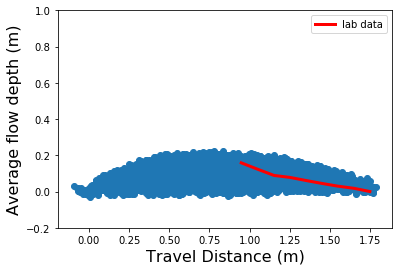

In [39]:
# deposition profile
m_3s=timestep(df,3,0.0101419,2271)
print m_3s.head()
rotated=rotation(m_3s,-30)
#plot the deposition data
labshift=lab_deposition[0]+0.95
plt.plot(labshift,lab_deposition[1].tolist(),linewidth=3,color='r',label='lab data')
plt.scatter(rotated[:,0],rotated[:,2])
plt.ylim(-0.2,1)
plt.legend()
plt.xlabel('Travel Distance (m)', fontsize=16)
plt.ylabel('Average flow depth (m)', fontsize=16)
plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/depopoints.png",dpi=3000)
plt.show()
plt.close()

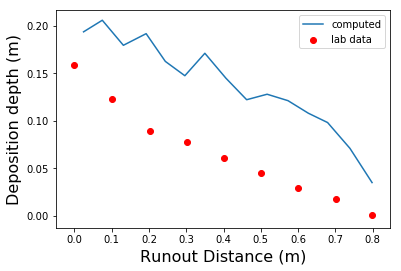

In [29]:
dfrotation=pd.DataFrame(data=rotated,
                        index=range(len(rotated)),columns=['x','y','z'])
outliney,outlinex=outline(dfrotation,10,0.05)
outlinex[:]=[x-0.95 for x in outlinex]
mpm=plt.plot(outlinex[19:],outliney[19:],label='computed')
lab=plt.scatter(lab_deposition[0].tolist(),lab_deposition[1].tolist(),color='r',label='lab data')
plt.legend()
plt.xlabel('Runout Distance (m)', fontsize=16)
plt.ylabel('Deposition depth (m)', fontsize=16)
plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/deposition.png",dpi=3000)
plt.show()
plt.close()

In [ ]:
#average flow depth comparison
m_3s=timestep(df,1,0.0101419,2271)
plt.scatter(m_3s.x,m_3s.z)
plt.ylim(-0.1,0.2)
plt.show()
runout,depth=RunoutDistance_depth(m_3s.x.tolist(),m_3s.y.tolist(),m_3s.z.tolist())
length=flowLength(m_3s.x,m_3s.y,m_3s.z)
print runout,depth,length

In [ ]:
outliney,outlinex=outline(m_3s,10,0.2)
plt.scatter(outlinex,outliney)
plt.xlim(1,5)
plt.ylim(-0.2,0.2)
plt.show()

301
301
301
301
301
301
301
301
301
301


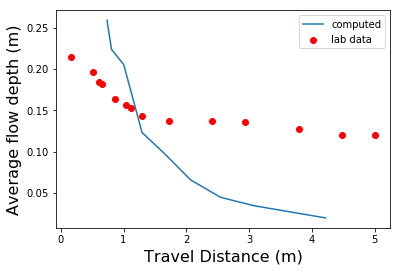

In [38]:
#outline of the debris flow
distx=[]
avgdepth=[]
for i in range(10):
    mtemp=timestep(df,i/10.,0.0101419,2271)# pay attention to the integer divide
    outliney,outlinex=outline(mtemp,10,0.2) 
    distx.append(mtemp.x.max())
    avgdepth.append(sum(outliney)/len(outliney))
mpmavg=plt.scatter(lab_flowDepth[0]*5,lab_flowDepth[1],color='r',label='lab data')
labavg=plt.plot(distx,avgdepth,label='computed')
plt.legend()
plt.xlabel('Travel Distance (m)', fontsize=16)
plt.ylabel('Average flow depth (m)', fontsize=16)
plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/avgflowdepth.png",dpi=3000)
plt.show()
plt.close()

301
301
301
301
301
301
301
301
301
301


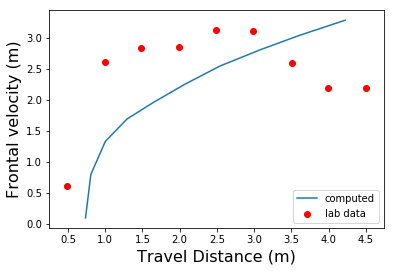

In [35]:
v_distx=[]
velocity=[]
for i in range(10):
    mtemp=timestep(df,i/10.,0.0101419,2271)# pay attention to the integer divide 
    v_distx.append(mtemp.x.max())
    velocity.append(mtemp.v.max())
velocity[:]=[x/2 for x in velocity]
plt.plot(v_distx,velocity,label='computed')
plt.scatter(lab_velocity[0]*5,lab_velocity[1],color='r',label='lab data')
plt.legend(loc='lower right')
plt.xlabel('Travel Distance (m)', fontsize=16)
plt.ylabel('Frontal velocity (m)', fontsize=16)
plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/velocity.png",dpi=3000)
plt.show()
plt.close()

## 2. impact

In [21]:
def plot_v1(data):
    # Create the figure and axis objects I'll be plotting on
    fig, ax = plt.subplots()
    
    # Plot the bars
    ax.bar(np.arange(len(data)), data, align='center')
    
    # 
    ax.hlines(19.5, -0.5, 5.5, linestyle='--', linewidth=1)
    
    # Set a reasonable y-axis limit
    ax.set_ylim(0, 40)
    
    # Apply labels to the bars so you know which is which
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels(["\n".join(x) for x in data.index])
    
    return fig, ax


plot_v1(tasks);

NameError: name 'tasks' is not defined

In [6]:
# deposition profile 
#path2='F:\\output\\slump2\\impact\\3\\impact.dat'
path2='../../presentation/2017-work report/impact/inertial num/30/impact.dat'
df2=pd.read_csv(path2,names=['data'])
df2=processdataframe_7variables(df2)

/home/wangchao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


          x         y         z       seqv       ep         p         v
1 -0.375213  0.009997  0.251537   0.959372  2650.13  -835.766  0.078093
2 -0.369566  0.009996  0.247826  10.000000  2650.15  -953.381  0.079033
3 -0.363918  0.009996  0.244114  10.000000  2650.17 -1045.670  0.080133
4 -0.358271  0.009995  0.240402  10.000000  2650.13  -799.710  0.081508
5 -0.352623  0.009995  0.236690  10.000000  2650.08  -531.134  0.083205


In [7]:
# deposition profile 
#path2='F:\\output\\slump2\\impact\\3\\impact.dat'
path40='../../presentation/2017-work report/impact/inertial num/40/impact.dat'
df40=pd.read_csv(path40,names=['data'])
df40=processdataframe_7variables(df40)

/home/wangchao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


          x         y         z          seqv       ep        p         v
1 -0.374868  0.009998  0.251520  2.876990e-01  2650.11 -775.713  0.109770
2 -0.369222  0.009998  0.247810  3.531220e-10  2650.12 -734.862  0.110818
3 -0.363577  0.009997  0.244099  4.822030e-10  2650.12 -753.628  0.111861
4 -0.357932  0.009997  0.240388  1.000000e+01  2650.11 -689.274  0.112956
5 -0.352286  0.009997  0.236677  1.000000e+01  2650.08 -473.346  0.114154


In [8]:
# deposition profile 
#path2='F:\\output\\slump2\\impact\\3\\impact.dat'
path50='../../presentation/2017-work report/impact/inertial num/50/impact.dat'
df50=pd.read_csv(path50,names=['data'])
df50=processdataframe_7variables(df50)

/home/wangchao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


          x         y         z          seqv       ep        p         v
1 -0.374571  0.009999  0.251570  4.829120e-01  2650.07 -529.501  0.135995
2 -0.368928  0.009998  0.247861  1.487200e-01  2650.07 -449.246  0.137017
3 -0.363284  0.009998  0.244151  8.833550e-10  2650.07 -422.179  0.138007
4 -0.357640  0.009998  0.240442  1.000000e+01  2650.11 -678.142  0.138927
5 -0.351997  0.009998  0.236732  1.000000e+01  2650.08 -475.102  0.139764


101


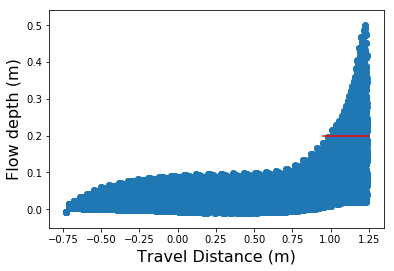

In [19]:
impact2=timestep(df2,1.0,0.020017,15870)
shearalongdepth2=[]
depth2=[]
for i in range(len(impact2)):
    if impact2.iat[i,2]>0.198 and impact2.iat[i,2]<0.2:
        shearalongdepth2.append(impact2.iat[i,3])
        depth2.append(impact2.iat[i,0])
plt.scatter(impact2.x.tolist(),impact2.z.tolist())
plt.plot([0.95,1.25],[0.2,0.2],color='r')
plt.xlabel('Travel Distance (m)', fontsize=16)
plt.ylabel('Flow depth (m)', fontsize=16)
#plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/30scatter.png",dpi=3000)
plt.show()
plt.close()

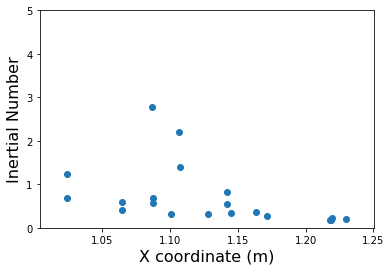

In [20]:
plt.scatter(depth2,shearalongdepth2)
plt.ylim(0,5)
plt.xlabel('X coordinate (m)', fontsize=16)
plt.ylabel('Inertial Number', fontsize=16)
#plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/30.png",dpi=3000)
plt.show()
plt.close()

99


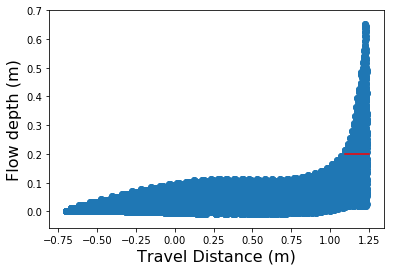

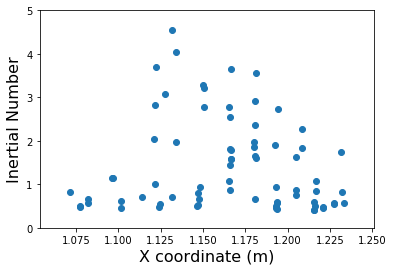

In [12]:
impact40=timestep(df40,0.65,0.020017,15870)
shearalongdepth40=[]
depth40=[]
for i in range(len(impact40)):
    if impact40.iat[i,2]>0.19 and impact40.iat[i,2]<0.2:
        shearalongdepth40.append(impact40.iat[i,3])
        depth40.append(impact40.iat[i,0])
plt.scatter(impact40.x.tolist(),impact40.z.tolist())
plt.plot([1.1,1.25],[0.2,0.2],color='r')
plt.xlabel('Travel Distance (m)', fontsize=16)
plt.ylabel('Flow depth (m)', fontsize=16)
#plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/40scatter.png",dpi=3000)
plt.show()
plt.close()
plt.scatter(depth40,shearalongdepth40)
plt.ylim(0,5)
plt.xlabel('X coordinate (m)', fontsize=16)
plt.ylabel('Inertial Number', fontsize=16)
#plt.savefig("C:/Users/ChaoWANG/OneDrive - HKUST Connect/presentation/2017-7-11/figure/40.png",dpi=3000)
plt.show()
plt.close()

In [ ]:
impact50=timestep(df50,1.0,0.020017,15870)
shearalongdepth50=[]
depth50=[]
for i in range(len(impact50)):
    if impact50.iat[i,2]>0.0998 and impact50.iat[i,2]<0.1:
        shearalongdepth50.append(impact50.iat[i,3])
        depth50.append(impact50.iat[i,0])        
plt.scatter(depth50,shearalongdepth50)
plt.show()

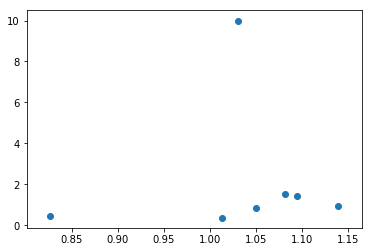